#### Using geospatialGPU as environment

In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

PyTorch version: 2.1.2
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
import rasterio

with rasterio.open('data/dataset/trainning/imgs/row10-col24.tif') as src:
    print("波段数量：", src.count)
    print("图像尺寸：", src.width, "x", src.height)
    print("波段数据类型：", src.dtypes)
    print("坐标参考系统 (CRS)：", src.crs)
    print("仿射变换（空间分辨率和原点）：", src.transform)
    print("每个波段的统计信息（前几个像素值）:")
    
    for i in range(1, src.count + 1):
        band = src.read(i)
        print(f"Band {i} - min: {band.min()}, max: {band.max()}, mean: {band.mean()}")

波段数量： 5
图像尺寸： 57 x 58
波段数据类型： ('uint16', 'uint16', 'uint16', 'uint16', 'uint16')
坐标参考系统 (CRS)： EPSG:4326
仿射变换（空间分辨率和原点）： | 0.00, 0.00, 119.81|
| 0.00,-0.00, 30.51|
| 0.00, 0.00, 1.00|
每个波段的统计信息（前几个像素值）:
Band 1 - min: 0, max: 1712, mean: 1207.3832425892317
Band 2 - min: 0, max: 1960, mean: 1401.8221415607986
Band 3 - min: 0, max: 1924, mean: 1239.6548699334544
Band 4 - min: 0, max: 4844, mean: 3556.5459770114944
Band 5 - min: 0, max: 3449, mean: 2836.2649727767694


In [3]:
#!pip install scikit-image

In [1]:
from torchvision.models import resnet50
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
# import matplotlib.pyplot as plt
import time
import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage import io, transform
from skimage.transform import rotate, AffineTransform, warp
import rasterio as rio
from torchvision.transforms import Resize, CenterCrop, Normalize
import torchvision.transforms as transforms
from scipy import ndimage
import rasterio
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# 1. Build a UNet

In [3]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        #parameters: in_channels, out_channels, kernel_size, padding
        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        
        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)
        
    # will be call when create instance
    def __call__(self, x): 
        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        
        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        
        return upconv1
    
    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )
        
        return contract
    
    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [4]:
unet = UNET(4, 3)
unet

UNET(
  (conv1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

In [5]:
# 2. Convert the NAIP images and land use mp into the format that can be trained

In [6]:
#!pip install albumentations

In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset
import rasterio
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage import transform

transform_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    ToTensorV2()
])

class CanopyDataset(Dataset):
    def __init__(self, img_dir, msk_dir, pytorch=True, transforms=None):
        super().__init__()
        self.files = [self.combine_files(f, img_dir, msk_dir) for f in img_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        self.transforms = transforms

    def combine_files(self, r_file: Path, img_dir, msk_dir):
        files = {
            'image': r_file,
            'mask': msk_dir / r_file.name.replace('naip_tiles', 'lu_masks')
        }
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # ---- 读取图像和选取四个波段 ----
        with rasterio.open(self.files[idx]['image']) as src:
            img = src.read()  # (5, H, W)
            img = img[[1, 2, 3, 4], :, :]  # B3, B4, B8, B11

        with rasterio.open(self.files[idx]['mask']) as src:
            mask = src.read(1)  # (H, W)

        # ---- resize 图像和 mask ----
        img = transform.resize(img, (4, 512, 512), preserve_range=True).astype(np.float32)
        mask = transform.resize(mask, (512, 512), order=0, preserve_range=True).astype(np.uint8)

        # ---- remap 标签 ----
        class_map = {
            1: [2, 3, 4, 5, 7,8, 9, 10],   # 其他
            2: [1, 6],            # 不透水
            0: [0],               # NoData
        }

        mask_remap = np.zeros_like(mask, dtype=np.uint8)
        for new_val, raw_vals in class_map.items():
            for raw_val in raw_vals:
                mask_remap[mask == raw_val] = new_val

        # ---- 数据增强 ----
        if self.transforms:
            aug = self.transforms(image=img.transpose(1, 2, 0), mask=mask_remap)
            img = aug['image']          # (H, W, C)
            mask_remap = aug['mask']    # (H, W)
        else:
            img = torch.tensor(img, dtype=torch.float32)
            mask_remap = torch.tensor(mask_remap, dtype=torch.int64)

        # ---- 归一化 ----
        img = img / 10000.0  # Sentinel 通常使用这个比例

        return img, mask_remap

    def __repr__(self):
        return f'Dataset class with {len(self)} files'

In [8]:
from torch.utils.data import DataLoader
from pathlib import Path

base_path = Path('data/dataset/trainning')

data = CanopyDataset(base_path / 'imgs', 
                          base_path / 'labels', 
                          transforms=transform_aug)

data_size = len(data)
training_size = int(data_size * 0.8)
testing_size = data_size - training_size

train_ds, valid_ds = torch.utils.data.random_split(data, (training_size, testing_size))

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=False)

print('train_dl size:', len(train_dl))
print('valid_dl size:', len(valid_dl))

train_dl size: 1647
valid_dl size: 412


In [9]:
# 查看data中的第一个样本的标签
img, label = data[10]

# 打印标签的唯一值
print(np.unique(label.numpy()))  # 转换为NumPy数组后查看唯一值

[0 1 2]


In [10]:
# 3. Start training

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
import time
import torch

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1, patience=10, model_path='best_model.pth'):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0
    early_stop_counter = 0

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            model.train(phase == 'train')
            dataloader = train_dl if phase == 'train' else valid_dl

            running_loss = 0.0
            running_acc = 0.0
            step = 0

            for x, y in dataloader:
                x, y = x.to(device), y.to(device).long()  # Ensure the target 'y' is long type for loss computation
                step += 1

                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(x)  # Assuming the model outputs are logits for classification
                    loss = loss_fn(outputs, y)  # Loss function for classification
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y)

                acc = acc_fn(outputs, y)  # Accuracy metric
                running_acc += acc * x.size(0)  # Accumulate accuracy for batch
                running_loss += loss * x.size(0)  # Accumulate loss for batch

                if step % 100 == 0:
                    print(f'Current step: {step}  Loss: {loss:.4f}  Acc: {acc:.4f}  AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.2f}')

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print('-' * 10)

            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                valid_loss.append(epoch_loss)

                # Check for best model
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), model_path)
                    print(f"✨ Best model saved with acc {best_acc:.4f}")
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1} (no improvement in {patience} epochs)")
            break

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return train_loss, valid_loss


def batch_to_img(xb, idx):
    img = np.array(xb[idx, 0:3])  # Convert the batch to an image (assuming 3 channels for RGB)
    return img.transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)


def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)  # Apply softmax to the prediction logits
    return p.argmax(0).cpu()  # Return the class with the highest probability


def acc_metric(predb, yb):
    # The outputs are in shape [B, C, H, W], so we compare the predicted class with the ground truth
    return (predb.argmax(dim=1) == yb).float().mean()  # Average the accuracy over the batch

In [13]:
unet = UNET(4, 3).to(device) #输入通道为4（绿+红+近红外+SWIR1）, 输出通道为4（4个类别）

In [14]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)

train_loss, valid_loss = train(
    unet,
    train_dl,
    valid_dl,
    loss_fn,
    opt,
    acc_metric,
    epochs=50,
    patience=5,  # 如果连续5轮验证集准确率没有提升就早停
    model_path='unet_third_model.pth'
)

Epoch 1/50
----------
Current step: 100  Loss: 0.7066  Acc: 0.5952  AllocMem (Mb): 44.30
Current step: 200  Loss: 1.3760  Acc: 0.2860  AllocMem (Mb): 44.30
Current step: 300  Loss: 0.4912  Acc: 0.7783  AllocMem (Mb): 44.30
Current step: 400  Loss: 0.5353  Acc: 0.7465  AllocMem (Mb): 44.30
Current step: 500  Loss: 0.3109  Acc: 0.9024  AllocMem (Mb): 44.30
Current step: 600  Loss: 0.3796  Acc: 0.8032  AllocMem (Mb): 44.30
Current step: 700  Loss: 0.5782  Acc: 0.7356  AllocMem (Mb): 44.30
Current step: 800  Loss: 0.4458  Acc: 0.8076  AllocMem (Mb): 44.30
Current step: 900  Loss: 0.3694  Acc: 0.8420  AllocMem (Mb): 44.30
Current step: 1000  Loss: 0.3760  Acc: 0.8599  AllocMem (Mb): 44.30
Current step: 1100  Loss: 0.4261  Acc: 0.8210  AllocMem (Mb): 44.30
Current step: 1200  Loss: 0.8912  Acc: 0.5795  AllocMem (Mb): 44.30
Current step: 1300  Loss: 0.3497  Acc: 0.8543  AllocMem (Mb): 44.30
Current step: 1400  Loss: 0.5522  Acc: 0.7552  AllocMem (Mb): 44.30
Current step: 1500  Loss: 0.3857  A

In [ ]:
# 4. Predict

In [15]:
def combine_files(r_file: Path, img_dir, msk_dir):
    files = {'image': r_file, 
             'mask': msk_dir/r_file.name.replace('naip_tiles', 'lu_masks')}
    
    print('r_file is:', r_file)
    print('msk_dir:', msk_dir)
    print('r_file.name is:', r_file.name.replace('naip_tiles', 'lu_masks'))
    print('The mas file is: -----', msk_dir/r_file.name.replace('naip_tiles', 'lu_masks'))
    return files

In [16]:
base_path = Path('data/dataset/trainning')
# data = CanopyDataset(base_path/'imgs', 
#                     base_path/'labels')

img_dir = base_path/'imgs'
msk_dir = base_path/'labels'
img_dir, msk_dir

(WindowsPath('data/dataset/trainning/imgs'),
 WindowsPath('data/dataset/trainning/labels'))

In [17]:
# Loop through the files in red folder and combine, into a dictionary, the other bands
self_files = [combine_files(f, img_dir, msk_dir) for f in img_dir.iterdir() if not f.is_dir()]
self_files

r_file is: data\dataset\trainning\imgs\row0-col5.tif
msk_dir: data\dataset\trainning\labels
r_file.name is: row0-col5.tif
The mas file is: ----- data\dataset\trainning\labels\row0-col5.tif
r_file is: data\dataset\trainning\imgs\row0-col6.tif
msk_dir: data\dataset\trainning\labels
r_file.name is: row0-col6.tif
The mas file is: ----- data\dataset\trainning\labels\row0-col6.tif
r_file is: data\dataset\trainning\imgs\row1-col2.tif
msk_dir: data\dataset\trainning\labels
r_file.name is: row1-col2.tif
The mas file is: ----- data\dataset\trainning\labels\row1-col2.tif
r_file is: data\dataset\trainning\imgs\row1-col3.tif
msk_dir: data\dataset\trainning\labels
r_file.name is: row1-col3.tif
The mas file is: ----- data\dataset\trainning\labels\row1-col3.tif
r_file is: data\dataset\trainning\imgs\row1-col4.tif
msk_dir: data\dataset\trainning\labels
r_file.name is: row1-col4.tif
The mas file is: ----- data\dataset\trainning\labels\row1-col4.tif
r_file is: data\dataset\trainning\imgs\row1-col5.tif
ms

[{'image': WindowsPath('data/dataset/trainning/imgs/row0-col5.tif'),
  'mask': WindowsPath('data/dataset/trainning/labels/row0-col5.tif')},
 {'image': WindowsPath('data/dataset/trainning/imgs/row0-col6.tif'),
  'mask': WindowsPath('data/dataset/trainning/labels/row0-col6.tif')},
 {'image': WindowsPath('data/dataset/trainning/imgs/row1-col2.tif'),
  'mask': WindowsPath('data/dataset/trainning/labels/row1-col2.tif')},
 {'image': WindowsPath('data/dataset/trainning/imgs/row1-col3.tif'),
  'mask': WindowsPath('data/dataset/trainning/labels/row1-col3.tif')},
 {'image': WindowsPath('data/dataset/trainning/imgs/row1-col4.tif'),
  'mask': WindowsPath('data/dataset/trainning/labels/row1-col4.tif')},
 {'image': WindowsPath('data/dataset/trainning/imgs/row1-col5.tif'),
  'mask': WindowsPath('data/dataset/trainning/labels/row1-col5.tif')},
 {'image': WindowsPath('data/dataset/trainning/imgs/row1-col6.tif'),
  'mask': WindowsPath('data/dataset/trainning/labels/row1-col6.tif')},
 {'image': WindowsPa

In [18]:
def batch_to_img(xb, idx):
    img = xb[idx, [0,1,2]].detach().cpu().numpy()  # R, G, B

    img = img.transpose(1, 2, 0)  # CHW -> HWC
    img = (img - img.min()) / (img.max() - img.min() + 1e-5)
    return img

torch.Size([4, 4, 512, 512]) torch.Size([4, 512, 512])


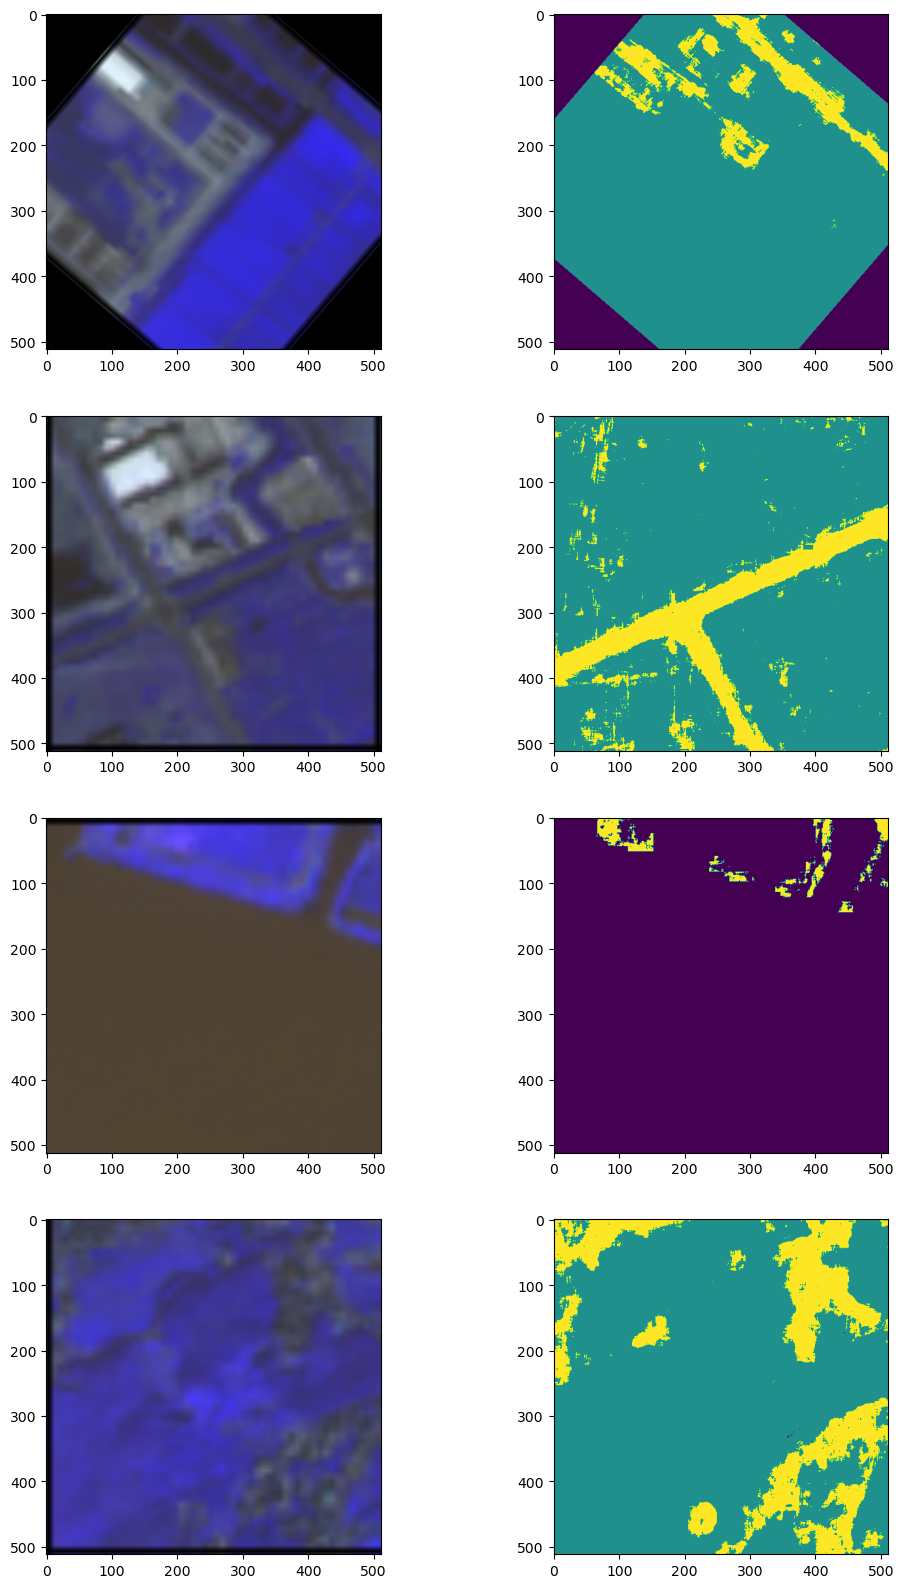

In [19]:
# Check the image and the label data
from matplotlib import pyplot as plt

xb, yb = next(iter(train_dl))
print(xb.shape, yb.shape)

bs = 4
fig, ax = plt.subplots(bs, 2, figsize=(12, bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])

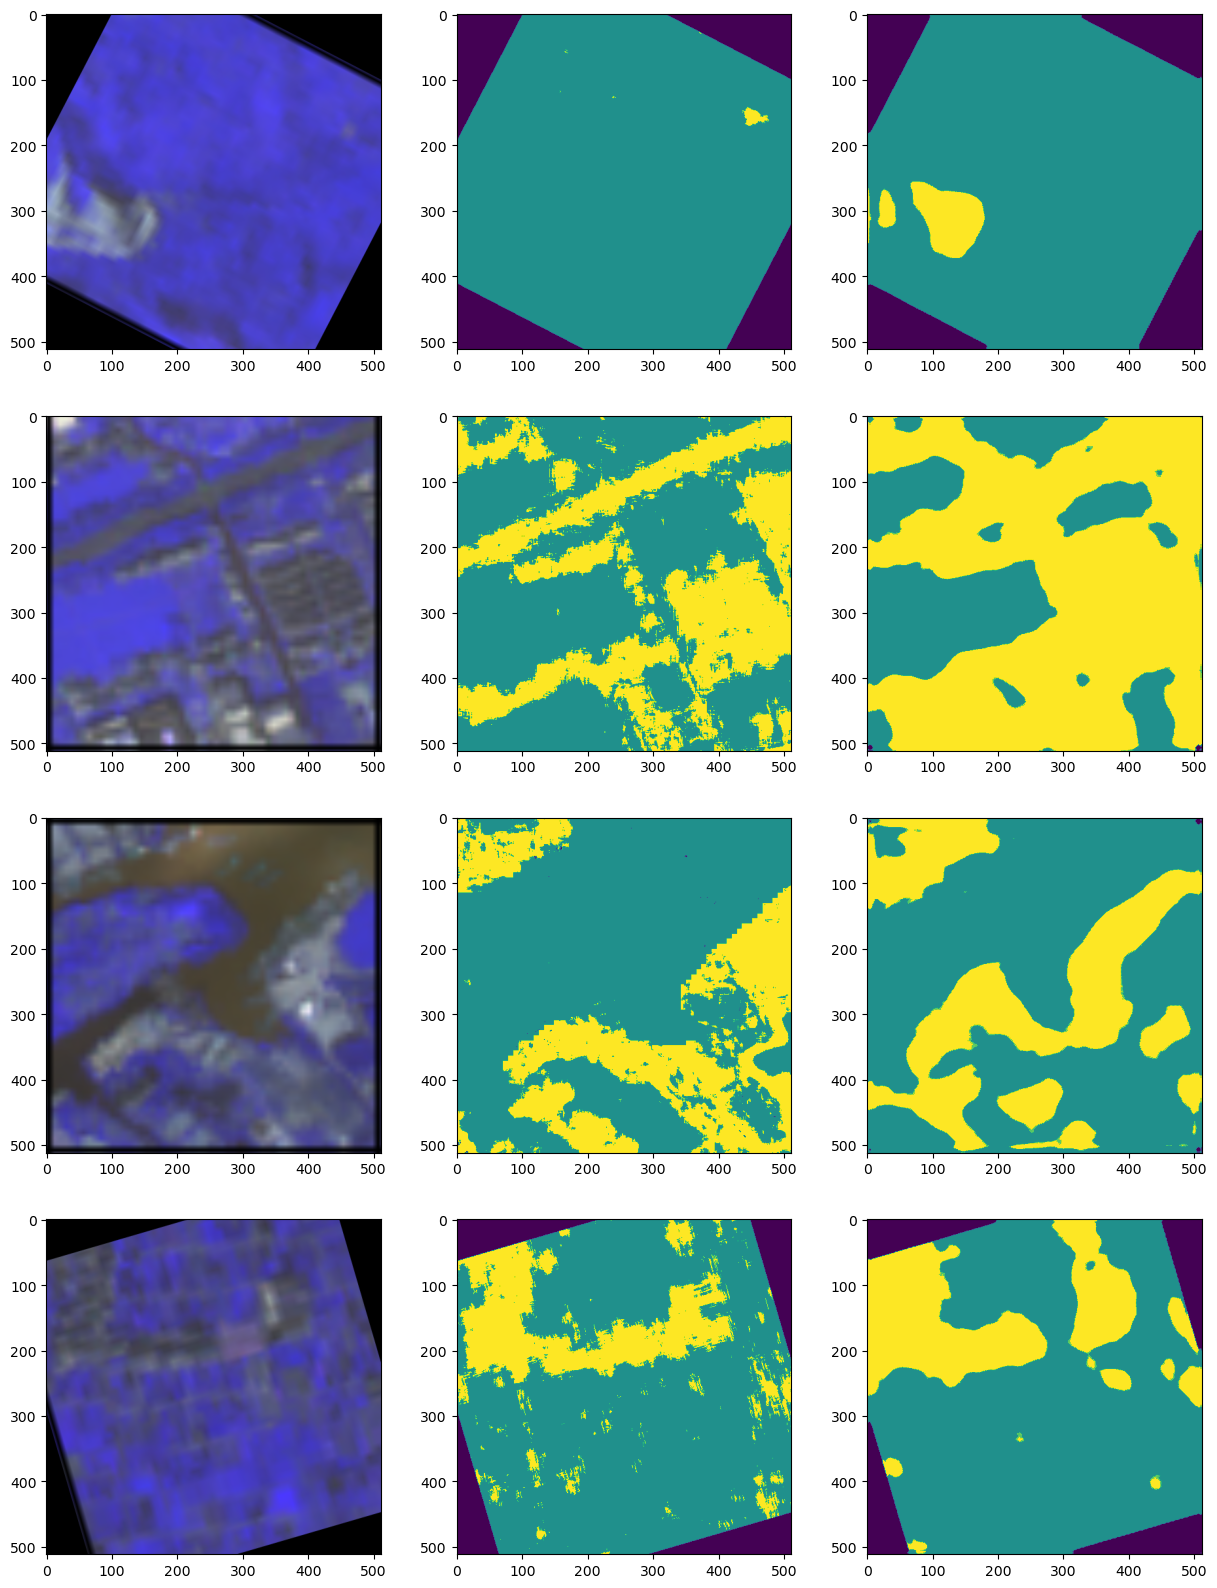

In [22]:
# compare the model prediction and the reference data
model = UNET(4,3)

model_path =Path('unet_third_model.pth')
model.load_state_dict(torch.load(model_path))

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = model(xb)

## batch size
bs = 4
fig, ax = plt.subplots(bs, 3, figsize=(15, bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))
    